Running Model-22: 4500it [00:02, 1528.37it/s]<?, ?it/s]
Running Model-22: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Fitting node Ridge-22...


Running Model-22: 490it [00:00, 1756.36it/s]           


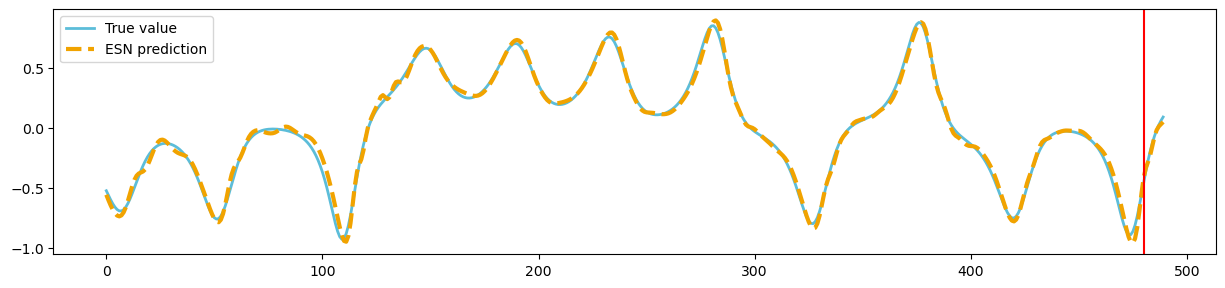

In [29]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import numpy as np
import math
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp

length = 5000
train = 4500
forecast = 10

###ПОДГОТОВКА ДАННЫХ
#9
import warnings
from nolitsa import data

dt = 0.01
x0 = [0.62225717, -0.08232857, 30.60845379]

#000
x1 = data.lorenz(length=6500, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

#11
import copy
time = copy.deepcopy(x1) 
X1 = time[:,0] 
X1 = X1.reshape(6500,1) 
X1 = 2 * (X1 - X1.min()) / (X1.max() - X1.min()) - 1 
#000
    
X = X1[:5000]


def results(y_pred, y_test):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    #ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    #ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")

    ax.plot(np.arange(len(y_test)), y_test, lw=2, label="True value", color="#5cbdd9")
    ax.plot(np.arange(len(y_pred)), y_pred, lw=3, label="ESN prediction", color="#f1a300", linestyle="--")
    ax.axvline(x=len(y_test)-forecast, color="red")  # Add vertical line
    ax.legend()
    plt.show()
    
###HERE0
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=forecast)

X_train1, y_train1 = x[:train], y[:train]
X_test1, y_test1 = x[train:], y[train:]

#Первый тестовый набор параметров 
units = 100
leak_rate = 0.3 #коэффициент утечки от 0 до 1
spectral_radius = 1.25 #от 0.1 до 1
input_scaling = 1.0
connectivity = 1.0 #от 0 до 1
input_connectivity = 0.2 #тоже %
regularization = 1e-8
seed = 1234

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1, reset=False)
results(y_pred1, X[train+forecast:])
###HERE1

In [30]:
def rmse(x_test, x_sim):
        res = 0
        for i in range(len(x_sim)):
            res = res + (x_sim[i] - x_test[i])**2
        res = math.sqrt(res/len(x_sim))
        return res

In [31]:
rmse(y_pred1[-100:], X[-100:])

C:\Users\nicks\AppData\Local\Temp\ipykernel_7112\1113348330.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))


0.03752126275894335

In [32]:
BestRmse = 0.03752126275894335
BestHyp = np.empty((8, 1))

BestHyp[0] = 100
BestHyp[1] = 0.3
BestHyp[2] = 1.25
BestHyp[3] = 1.0
BestHyp[4] = 1.0
BestHyp[5] = 0.2
BestHyp[6] = 1e-8
BestHyp[7] = 1234

In [33]:
Seed = np.arange(1234, 1734, 300)
Regularization = np.arange(1e-8, 1.0, 0.5)
Input_connectivity = np.arange(0.01, 1.0, 0.5)
Connectivity = np.arange(0.01, 1.0, 0.5)
Input_scaling = np.arange(1.0, 5.0, 2.0)
Spectral_radius = np.arange(0.1, 1.0, 0.5)
Leak_rate = np.arange(0.05, 1.0, 0.5)
Units = np.arange(30, 1000, 400)

In [34]:
for q in range(len(Units)):
    for w in range(len(Leak_rate)):
        for e in range(len(Spectral_radius)):
            for r in range(len(Input_scaling)):
                for t in range(len(Connectivity)):
                    for z in range(len(Input_connectivity)):
                        for u in range(len(Regularization)):
                            for a in range(len(Seed)):
                                #Первый тестовый набор параметров 
                                units = Units[q]
                                leak_rate = Leak_rate[w] #коэффициент утечки от 0 до 1
                                spectral_radius = Spectral_radius[e] #от 0.1 до 1
                                input_scaling = Input_scaling[r]
                                connectivity = Connectivity[t] #от 0 до 1
                                input_connectivity = Input_connectivity[z] #тоже %
                                regularization = Regularization[u]
                                seed = Seed[a]

                                #узел резервуара
                                reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                                                    lr=leak_rate, rc_connectivity=connectivity,
                                                    input_connectivity=input_connectivity, seed=seed)
                                #выходной слой(считывающее устройство)
                                readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
                                #соединяем узлы и таким образом получаем модель 
                                esn = reservoir >> readout

                                #обучение модели
                                esn = esn.fit(X_train1, y_train1)
                                #делаем предсказание
                                y_pred1 = esn.run(X_test1, reset=False)
                                #results(y_pred1, X[train+forecast:])
                                Rmse = rmse(y_pred1[-100:], X[-100:])
                                if (Rmse<BestRmse):
                                    BestRmse = Rmse
                                    BestHyp[0] = Units[q]
                                    BestHyp[1] = Leak_rate[w]
                                    BestHyp[2] = Spectral_radius[e]
                                    BestHyp[3] = Input_scaling[r]
                                    BestHyp[4] = Connectivity[t]
                                    BestHyp[5] = Input_connectivity[z]
                                    BestHyp[6] = Regularization[u]
                                    BestHyp[7] = Seed[a]


Running Model-23:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-23: 4500it [00:01, 3318.60it/s]
Running Model-23: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Fitting node Ridge-23...


Running Model-23: 490it [00:00, 3043.55it/s]           
C:\Users\nicks\AppData\Local\Temp\ipykernel_7112\1113348330.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))
Running Model-24: 4500it [00:01, 4136.05it/s]<?, ?it/s]
Running Model-24: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Fitting node Ridge-24...


Running Model-24: 490it [00:00, 5764.80it/s]           
Running Model-25: 4500it [00:00, 5897.06it/s]<?, ?it/s]
Running Model-25: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-25...


Running Model-25: 490it [00:00, 5567.47it/s]           
Running Model-26: 4500it [00:00, 6859.77it/s]<?, ?it/s]
Running Model-26: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-26...


Running Model-26: 490it [00:00, 5880.90it/s]           
Running Model-27: 4500it [00:00, 5583.17it/s]<?, ?it/s]
Running Model-27: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-27...


Running Model-27: 490it [00:00, 5505.50it/s]           
Running Model-28: 4500it [00:00, 6912.34it/s]<?, ?it/s]
Running Model-28: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-28...


Running Model-28: 490it [00:00, 7101.25it/s]           
Running Model-29: 4500it [00:00, 5387.64it/s]<?, ?it/s]
Running Model-29: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Fitting node Ridge-29...


Running Model-29: 490it [00:00, 5975.56it/s]           
Running Model-30: 4500it [00:00, 6137.97it/s]<?, ?it/s]
Running Model-30: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-30...


Running Model-30: 490it [00:00, 6621.85it/s]           
Running Model-31: 4500it [00:00, 6676.50it/s]<?, ?it/s]
Running Model-31: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-31...


Running Model-31: 490it [00:00, 7206.00it/s]           
Running Model-32: 4500it [00:00, 6502.92it/s]<?, ?it/s]
Running Model-32: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-32...


Running Model-32: 490it [00:00, 5833.38it/s]           
Running Model-33: 4500it [00:00, 6278.43it/s]<?, ?it/s]
Running Model-33: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-33...


Running Model-33: 490it [00:00, 4999.67it/s]           
Running Model-34: 4500it [00:00, 6637.17it/s]<?, ?it/s]
Running Model-34: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-34...


Running Model-34: 490it [00:00, 7000.44it/s]           
Running Model-35: 4500it [00:00, 5948.84it/s]<?, ?it/s]
Running Model-35: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-35...


Running Model-35: 490it [00:00, 5697.74it/s]           
Running Model-36: 4500it [00:00, 6150.37it/s]<?, ?it/s]
Running Model-36: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-36...


Running Model-36: 490it [00:00, 6125.21it/s]           
Running Model-37: 4500it [00:00, 6171.28it/s]<?, ?it/s]
Running Model-37: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-37...


Running Model-37: 490it [00:00, 6282.99it/s]           
Running Model-38: 4500it [00:00, 6533.55it/s]<?, ?it/s]
Running Model-38: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-38...


Running Model-38: 490it [00:00, 7657.18it/s]           
Running Model-39: 4500it [00:00, 6611.32it/s]<?, ?it/s]
Running Model-39: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-39...


Running Model-39: 490it [00:00, 7654.98it/s]           
Running Model-40: 4500it [00:00, 6880.99it/s]<?, ?it/s]
Running Model-40: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-40...


Running Model-40: 490it [00:00, 6202.18it/s]           
Running Model-41: 4500it [00:00, 6692.66it/s]<?, ?it/s]
Running Model-41: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-41...


Running Model-41: 490it [00:00, 4414.43it/s]           
Running Model-42: 4500it [00:00, 6626.51it/s]<?, ?it/s]
Running Model-42: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-42...


Running Model-42: 490it [00:00, 7314.54it/s]           
Running Model-43: 4500it [00:00, 7153.02it/s]<?, ?it/s]
Running Model-43: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-43...


Running Model-43: 490it [00:00, 5833.13it/s]           
Running Model-44: 4500it [00:00, 6301.19it/s]<?, ?it/s]
Running Model-44: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-44...


Running Model-44: 490it [00:00, 7311.44it/s]           
Running Model-45: 4500it [00:00, 6997.16it/s]<?, ?it/s]
Running Model-45: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-45...


Running Model-45: 490it [00:00, 6125.41it/s]           
Running Model-46: 4500it [00:00, 5416.37it/s]<?, ?it/s]
Running Model-46: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-46...


Running Model-46: 490it [00:00, 7313.88it/s]           
Running Model-47: 4500it [00:00, 7223.23it/s]<?, ?it/s]
Running Model-47: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-47...


Running Model-47: 490it [00:00, 7313.65it/s]           
Running Model-48: 4500it [00:00, 7166.69it/s]<?, ?it/s]
Running Model-48: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-48...


Running Model-48: 490it [00:00, 7205.34it/s]           
Running Model-49: 4500it [00:00, 7120.07it/s]<?, ?it/s]
Running Model-49: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-49...


Running Model-49: 490it [00:00, 6700.87it/s]           
Running Model-50: 4500it [00:00, 6640.75it/s]<?, ?it/s]
Running Model-50: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-50...


Running Model-50: 490it [00:00, 6899.68it/s]           
Running Model-51: 4500it [00:00, 6890.18it/s]<?, ?it/s]
Running Model-51: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-51...


Running Model-51: 490it [00:00, 7000.56it/s]           
Running Model-52: 4500it [00:00, 7131.35it/s]<?, ?it/s]
Running Model-52: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-52...


Running Model-52: 490it [00:00, 7538.34it/s]           
Running Model-53: 4500it [00:00, 7234.67it/s]<?, ?it/s]
Running Model-53: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-53...


Running Model-53: 490it [00:00, 6712.62it/s]           
Running Model-54: 4500it [00:00, 7005.94it/s]<?, ?it/s]
Running Model-54: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-54...


Running Model-54: 490it [00:00, 7151.24it/s]           
Running Model-55: 4500it [00:00, 6162.73it/s]<?, ?it/s]
Running Model-55: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-55...


Running Model-55: 490it [00:00, 6446.74it/s]           
Running Model-56: 4500it [00:00, 7117.77it/s]<?, ?it/s]
Running Model-56: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-56...


Running Model-56: 490it [00:00, 5840.35it/s]           
Running Model-57: 4500it [00:00, 6063.52it/s]<?, ?it/s]
Running Model-57: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-57...


Running Model-57: 490it [00:00, 7538.90it/s]           
Running Model-58: 4500it [00:00, 6446.22it/s]<?, ?it/s]
Running Model-58: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-58...


Running Model-58: 490it [00:00, 8305.72it/s]           
Running Model-59: 4500it [00:00, 7117.44it/s]<?, ?it/s]
Running Model-59: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-59...


Running Model-59: 490it [00:00, 5212.05it/s]           
Running Model-60: 4500it [00:00, 6965.95it/s]<?, ?it/s]
Running Model-60: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-60...


Running Model-60: 490it [00:00, 7873.40it/s]           
Running Model-61: 4500it [00:00, 6174.06it/s]<?, ?it/s]
Running Model-61: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-61...


Running Model-61: 490it [00:00, 7206.78it/s]           
Running Model-62: 4500it [00:00, 5913.29it/s]<?, ?it/s]
Running Model-62: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-62...


Running Model-62: 490it [00:00, 6447.25it/s]           
Running Model-63: 4500it [00:00, 6771.62it/s]<?, ?it/s]
Running Model-63: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-63...


Running Model-63: 490it [00:00, 5975.28it/s]           
Running Model-64: 4500it [00:00, 7294.41it/s]<?, ?it/s]
Running Model-64: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-64...


Running Model-64: 490it [00:00, 7205.27it/s]           
Running Model-65: 4500it [00:00, 6465.47it/s]<?, ?it/s]
Running Model-65: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-65...


Running Model-65: 490it [00:00, 6804.02it/s]           
Running Model-66: 4500it [00:00, 6999.32it/s]<?, ?it/s]
Running Model-66: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-66...


Running Model-66: 490it [00:00, 6712.90it/s]           
Running Model-67: 4500it [00:00, 7258.36it/s]<?, ?it/s]
Running Model-67: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-67...


Running Model-67: 490it [00:00, 5834.72it/s]           
Running Model-68: 4500it [00:00, 7345.73it/s]<?, ?it/s]
Running Model-68: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-68...


Running Model-68: 490it [00:00, 7538.73it/s]           
Running Model-69: 4500it [00:00, 6870.24it/s]<?, ?it/s]
Running Model-69: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-69...


Running Model-69: 490it [00:00, 7023.95it/s]           
Running Model-70: 4500it [00:00, 6315.22it/s]<?, ?it/s]
Running Model-70: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-70...


Running Model-70: 490it [00:00, 7424.49it/s]           
Running Model-71: 4500it [00:00, 6986.63it/s]<?, ?it/s]
Running Model-71: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-71...


Running Model-71: 490it [00:00, 7902.58it/s]           
Running Model-72: 4500it [00:00, 6268.23it/s]<?, ?it/s]
Running Model-72: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-72...


Running Model-72: 490it [00:00, 5159.32it/s]           
Running Model-73: 4500it [00:00, 6891.30it/s]<?, ?it/s]
Running Model-73: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-73...


Running Model-73: 490it [00:00, 6621.01it/s]           
Running Model-74: 4500it [00:00, 6807.96it/s]<?, ?it/s]
Running Model-74: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-74...


Running Model-74: 490it [00:00, 6712.16it/s]           
Running Model-75: 4500it [00:00, 6550.23it/s]<?, ?it/s]
Running Model-75: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-75...


Running Model-75: 490it [00:00, 6712.57it/s]           
Running Model-76: 4500it [00:00, 5569.33it/s]<?, ?it/s]
Running Model-76: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-76...


Running Model-76: 490it [00:00, 6282.72it/s]           
Running Model-77: 4500it [00:00, 5611.00it/s]<?, ?it/s]
Running Model-77: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-77...


Running Model-77: 490it [00:00, 6124.97it/s]           
Running Model-78: 4500it [00:00, 6787.29it/s]<?, ?it/s]
Running Model-78: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-78...


Running Model-78: 490it [00:00, 6448.18it/s]           
Running Model-79: 4500it [00:00, 5724.16it/s]<?, ?it/s]
Running Model-79: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-79...


Running Model-79: 490it [00:00, 5631.80it/s]           
Running Model-80: 4500it [00:00, 6828.66it/s]<?, ?it/s]
Running Model-80: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-80...


Running Model-80: 490it [00:00, 8305.32it/s]           
Running Model-81: 4500it [00:00, 6569.42it/s]<?, ?it/s]
Running Model-81: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-81...


Running Model-81: 490it [00:00, 6533.50it/s]           
Running Model-82: 4500it [00:00, 6731.34it/s]<?, ?it/s]
Running Model-82: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-82...


Running Model-82: 490it [00:00, 4472.05it/s]           
Running Model-83: 4500it [00:00, 7461.87it/s]<?, ?it/s]
Running Model-83: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-83...


Running Model-83: 490it [00:00, 6049.38it/s]           
Running Model-84: 4500it [00:00, 7009.37it/s]<?, ?it/s]
Running Model-84: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-84...


Running Model-84: 490it [00:00, 7205.72it/s]           
Running Model-85: 4500it [00:00, 6139.04it/s]<?, ?it/s]
Running Model-85: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-85...


Running Model-85: 490it [00:00, 6447.86it/s]           
Running Model-86: 4500it [00:00, 6609.47it/s]<?, ?it/s]
Running Model-86: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-86...


Running Model-86: 490it [00:00, 7206.23it/s]           
Running Model-87: 4500it [00:00, 7108.96it/s]<?, ?it/s]
Running Model-87: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-87...


Running Model-87: 490it [00:00, 7000.29it/s]           
Running Model-88: 4500it [00:00, 7293.06it/s]<?, ?it/s]
Running Model-88: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-88...


Running Model-88: 490it [00:00, 6781.75it/s]           
Running Model-89: 4500it [00:00, 7126.91it/s]<?, ?it/s]
Running Model-89: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-89...


Running Model-89: 490it [00:00, 3858.19it/s]           
Running Model-90: 4500it [00:00, 6923.02it/s]<?, ?it/s]
Running Model-90: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-90...


Running Model-90: 490it [00:00, 7206.28it/s]           
Running Model-91: 4500it [00:00, 6789.78it/s]<?, ?it/s]
Running Model-91: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-91...


Running Model-91: 490it [00:00, 5325.62it/s]           
Running Model-92: 4500it [00:00, 6111.93it/s]<?, ?it/s]
Running Model-92: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-92...


Running Model-92: 490it [00:00, 8909.50it/s]           
Running Model-93: 4500it [00:00, 7188.52it/s]<?, ?it/s]
Running Model-93: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-93...


Running Model-93: 490it [00:00, 6999.91it/s]           
Running Model-94: 4500it [00:00, 6172.84it/s]<?, ?it/s]
Running Model-94: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-94...


Running Model-94: 490it [00:00, 8032.58it/s]           
Running Model-95: 4500it [00:00, 7550.37it/s]<?, ?it/s]
Running Model-95: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-95...


Running Model-95: 490it [00:00, 7101.38it/s]           
Running Model-96: 4500it [00:00, 7413.47it/s]<?, ?it/s]
Running Model-96: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-96...


Running Model-96: 490it [00:00, 6999.08it/s]           
Running Model-97: 4500it [00:00, 5703.39it/s]<?, ?it/s]
Running Model-97: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-97...


Running Model-97: 490it [00:00, 6202.14it/s]           
Running Model-98: 4500it [00:00, 6002.97it/s]<?, ?it/s]
Running Model-98: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-98...


Running Model-98: 490it [00:00, 6780.83it/s]           
Running Model-99: 4500it [00:00, 7101.93it/s]<?, ?it/s]
Running Model-99: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-99...


Running Model-99: 490it [00:00, 7311.88it/s]           
Running Model-100: 4500it [00:00, 7318.48it/s]<?, ?it/s]
Running Model-100: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-100...


Running Model-100: 490it [00:00, 5697.47it/s]           
Running Model-101: 4500it [00:00, 6777.33it/s]<?, ?it/s]
Running Model-101: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-101...


Running Model-101: 490it [00:00, 7538.57it/s]           
Running Model-102: 4500it [00:00, 6981.66it/s]<?, ?it/s]
Running Model-102: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-102...


Running Model-102: 490it [00:00, 5902.82it/s]           
Running Model-103: 4500it [00:00, 6456.07it/s]<?, ?it/s]
Running Model-103: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-103...


Running Model-103: 490it [00:00, 7038.07it/s]           
Running Model-104: 4500it [00:00, 6573.40it/s]<?, ?it/s]
Running Model-104: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-104...


Running Model-104: 490it [00:00, 5833.59it/s]           
Running Model-105: 4500it [00:00, 7258.08it/s]<?, ?it/s]
Running Model-105: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-105...


Running Model-105: 490it [00:00, 7101.45it/s]           
Running Model-106: 4500it [00:00, 6938.73it/s]<?, ?it/s]
Running Model-106: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-106...


Running Model-106: 490it [00:00, 6621.67it/s]           
Running Model-107: 4500it [00:00, 6158.86it/s]<?, ?it/s]
Running Model-107: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-107...


Running Model-107: 490it [00:00, 7656.38it/s]           
Running Model-108: 4500it [00:00, 6736.56it/s]<?, ?it/s]
Running Model-108: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-108...


Running Model-108: 490it [00:00, 7422.69it/s]           
Running Model-109: 4500it [00:00, 7580.79it/s]<?, ?it/s]
Running Model-109: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-109...


Running Model-109: 490it [00:00, 5631.00it/s]           
Running Model-110: 4500it [00:00, 7140.89it/s]<?, ?it/s]
Running Model-110: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-110...


Running Model-110: 490it [00:00, 5631.17it/s]           
Running Model-111: 4500it [00:00, 6444.45it/s]<?, ?it/s]
Running Model-111: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-111...


Running Model-111: 490it [00:00, 7313.55it/s]           
Running Model-112: 4500it [00:00, 6308.50it/s]<?, ?it/s]
Running Model-112: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-112...


Running Model-112: 490it [00:00, 5902.60it/s]           
Running Model-113: 4500it [00:00, 7068.99it/s]<?, ?it/s]
Running Model-113: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-113...


Running Model-113: 490it [00:00, 8303.57it/s]           
Running Model-114: 4500it [00:00, 7529.65it/s]<?, ?it/s]
Running Model-114: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-114...


Running Model-114: 490it [00:00, 7537.07it/s]           
Running Model-115: 4500it [00:00, 6380.21it/s]<?, ?it/s]
Running Model-115: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-115...


Running Model-115: 490it [00:00, 7206.15it/s]           
Running Model-116: 4500it [00:00, 7056.23it/s]<?, ?it/s]
Running Model-116: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-116...


Running Model-116: 490it [00:00, 5891.42it/s]           
Running Model-117: 4500it [00:00, 6980.03it/s]<?, ?it/s]
Running Model-117: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-117...


Running Model-117: 490it [00:00, 5832.98it/s]           
Running Model-118: 4500it [00:00, 6293.08it/s]<?, ?it/s]
Running Model-118: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-118...


Running Model-118: 490it [00:00, 6901.65it/s]           
Running Model-119: 4500it [00:00, 6842.88it/s]<?, ?it/s]
Running Model-119: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-119...


Running Model-119: 490it [00:00, 4622.52it/s]           
Running Model-120: 4500it [00:00, 6355.94it/s]<?, ?it/s]
Running Model-120: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-120...


Running Model-120: 490it [00:00, 7000.08it/s]           
Running Model-121: 4500it [00:00, 5876.86it/s]<?, ?it/s]
Running Model-121: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-121...


Running Model-121: 490it [00:00, 6447.63it/s]           
Running Model-122: 4500it [00:00, 6883.78it/s]<?, ?it/s]
Running Model-122: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-122...


Running Model-122: 490it [00:00, 7777.99it/s]           
Running Model-123: 4500it [00:00, 6880.71it/s]<?, ?it/s]
Running Model-123: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-123...


Running Model-123: 490it [00:00, 6447.07it/s]           
Running Model-124: 4500it [00:00, 6987.54it/s]<?, ?it/s]
Running Model-124: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-124...


Running Model-124: 490it [00:00, 6621.29it/s]           
Running Model-125: 4500it [00:00, 5725.20it/s]<?, ?it/s]
Running Model-125: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-125...


Running Model-125: 490it [00:00, 7101.84it/s]           
Running Model-126: 4500it [00:00, 7234.70it/s]<?, ?it/s]
Running Model-126: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-126...


Running Model-126: 490it [00:00, 7102.16it/s]           
Running Model-127: 4500it [00:00, 6456.24it/s]<?, ?it/s]
Running Model-127: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-127...


Running Model-127: 490it [00:00, 7101.79it/s]           
Running Model-128: 4500it [00:00, 6859.83it/s]<?, ?it/s]
Running Model-128: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-128...


Running Model-128: 490it [00:00, 6125.37it/s]           
Running Model-129: 4500it [00:00, 6676.55it/s]<?, ?it/s]
Running Model-129: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-129...


Running Model-129: 490it [00:00, 8447.08it/s]           
Running Model-130: 4500it [00:00, 7203.98it/s]<?, ?it/s]
Running Model-130: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-130...


Running Model-130: 490it [00:00, 4374.70it/s]           
Running Model-131: 4500it [00:00, 7497.88it/s]<?, ?it/s]
Running Model-131: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-131...


Running Model-131: 490it [00:00, 6363.98it/s]           
Running Model-132: 4500it [00:00, 7412.38it/s]<?, ?it/s]
Running Model-132: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-132...


Running Model-132: 490it [00:00, 5568.49it/s]           
Running Model-133: 4500it [00:00, 6251.26it/s]<?, ?it/s]
Running Model-133: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-133...


Running Model-133: 490it [00:00, 7099.51it/s]           
Running Model-134: 4500it [00:00, 5929.85it/s]<?, ?it/s]
Running Model-134: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-134...


Running Model-134: 490it [00:00, 5765.43it/s]           
Running Model-135: 4500it [00:00, 6422.76it/s]<?, ?it/s]
Running Model-135: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-135...


Running Model-135: 490it [00:00, 8164.24it/s]           
Running Model-136: 4500it [00:00, 6306.21it/s]<?, ?it/s]
Running Model-136: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-136...


Running Model-136: 490it [00:00, 6621.97it/s]           
Running Model-137: 4500it [00:00, 6080.97it/s]<?, ?it/s]
Running Model-137: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-137...


Running Model-137: 490it [00:00, 7205.85it/s]           
Running Model-138: 4500it [00:00, 6114.21it/s]<?, ?it/s]
Running Model-138: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-138...


Running Model-138: 490it [00:00, 6364.35it/s]           
Running Model-139: 4500it [00:00, 6987.57it/s]<?, ?it/s]
Running Model-139: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-139...


Running Model-139: 490it [00:00, 5568.40it/s]           
Running Model-140: 4500it [00:00, 6288.99it/s]<?, ?it/s]
Running Model-140: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-140...


Running Model-140: 490it [00:00, 6048.52it/s]           
Running Model-141: 4500it [00:00, 6540.77it/s]<?, ?it/s]
Running Model-141: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-141...


Running Model-141: 490it [00:00, 5874.22it/s]           
Running Model-142: 4500it [00:00, 6250.01it/s]<?, ?it/s]
Running Model-142: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-142...


Running Model-142: 490it [00:00, 5833.57it/s]           
Running Model-143: 4500it [00:00, 5976.07it/s]<?, ?it/s]
Running Model-143: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-143...


Running Model-143: 490it [00:00, 5833.03it/s]           
Running Model-144: 4500it [00:00, 6215.52it/s]<?, ?it/s]
Running Model-144: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-144...


Running Model-144: 490it [00:00, 7310.50it/s]           
Running Model-145: 4500it [00:00, 7537.36it/s]<?, ?it/s]
Running Model-145: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-145...


Running Model-145: 490it [00:00, 4376.05it/s]           
Running Model-146: 4500it [00:00, 5428.21it/s]<?, ?it/s]
Running Model-146: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Fitting node Ridge-146...


Running Model-146: 490it [00:00, 3575.89it/s]           
Running Model-147: 4500it [00:00, 5119.50it/s]<?, ?it/s]
Running Model-147: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Fitting node Ridge-147...


Running Model-147: 490it [00:00, 7100.61it/s]           
Running Model-148: 4500it [00:00, 6126.23it/s]<?, ?it/s]
Running Model-148: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-148...


Running Model-148: 490it [00:00, 8306.76it/s]           
Running Model-149: 4500it [00:00, 7102.14it/s]<?, ?it/s]
Running Model-149: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-149...


Running Model-149: 490it [00:00, 6805.55it/s]           
Running Model-150: 4500it [00:00, 7535.34it/s]<?, ?it/s]
Running Model-150: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-150...


Running Model-150: 490it [00:00, 5569.88it/s]           
Running Model-151: 4500it [00:00, 6319.09it/s]<?, ?it/s]
Running Model-151: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-151...


Running Model-151: 490it [00:00, 6710.47it/s]           
Running Model-152: 4500it [00:00, 5784.01it/s]<?, ?it/s]
Running Model-152: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-152...


Running Model-152: 490it [00:00, 3450.37it/s]           
Running Model-153: 4500it [00:00, 4644.00it/s]<?, ?it/s]
Running Model-153: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Fitting node Ridge-153...


Running Model-153: 490it [00:00, 7653.78it/s]           
Running Model-154: 4500it [00:00, 4913.12it/s]<?, ?it/s]
Running Model-154: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-154...


Running Model-154: 490it [00:00, 5505.03it/s]           
Running Model-155: 4500it [00:00, 6401.15it/s]<?, ?it/s]
Running Model-155: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-155...


Running Model-155: 490it [00:00, 6202.79it/s]           
Running Model-156: 4500it [00:00, 6181.38it/s]<?, ?it/s]
Running Model-156: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-156...


Running Model-156: 490it [00:00, 7313.86it/s]           
Running Model-157: 4500it [00:00, 5078.95it/s]<?, ?it/s]
Running Model-157: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-157...


Running Model-157: 490it [00:00, 5903.47it/s]           
Running Model-158: 4500it [00:00, 5862.96it/s]<?, ?it/s]
Running Model-158: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-158...


Running Model-158: 490it [00:00, 5975.73it/s]           
Running Model-159: 4500it [00:01, 3749.99it/s]<?, ?it/s]
Running Model-159: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Fitting node Ridge-159...


Running Model-159: 490it [00:00, 2970.01it/s]           
Running Model-160: 4500it [00:01, 2754.02it/s]<?, ?it/s]
Running Model-160: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Fitting node Ridge-160...


Running Model-160: 490it [00:00, 3712.08it/s]           
Running Model-161: 4500it [00:01, 2598.12it/s]<?, ?it/s]
Running Model-161: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Fitting node Ridge-161...


Running Model-161: 490it [00:00, 4622.65it/s]           
Running Model-162: 4500it [00:01, 3904.52it/s]<?, ?it/s]
Running Model-162: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Fitting node Ridge-162...


Running Model-162: 490it [00:00, 4537.06it/s]           
Running Model-163: 4500it [00:01, 3414.17it/s]<?, ?it/s]
Running Model-163: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Fitting node Ridge-163...


Running Model-163: 490it [00:00, 2951.72it/s]           
Running Model-164: 4500it [00:01, 2801.80it/s]<?, ?it/s]
Running Model-164: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Fitting node Ridge-164...


Running Model-164: 490it [00:00, 4083.22it/s]           
Running Model-165: 4500it [00:01, 4342.85it/s]<?, ?it/s]
Running Model-165: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Fitting node Ridge-165...


Running Model-165: 490it [00:00, 2752.74it/s]           
Running Model-166: 4500it [00:01, 3564.84it/s]<?, ?it/s]
Running Model-166: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Fitting node Ridge-166...


Running Model-166: 490it [00:00, 3474.57it/s]           
Running Model-167: 4500it [00:00, 6756.72it/s]<?, ?it/s]
Running Model-167: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-167...


Running Model-167: 490it [00:00, 6048.86it/s]           
Running Model-168: 4500it [00:00, 7102.62it/s]<?, ?it/s]
Running Model-168: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-168...


Running Model-168: 490it [00:00, 6280.38it/s]           
Running Model-169: 4500it [00:00, 6901.86it/s]<?, ?it/s]
Running Model-169: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-169...


Running Model-169: 490it [00:00, 7656.38it/s]           
Running Model-170: 4500it [00:00, 5775.07it/s]<?, ?it/s]
Running Model-170: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Fitting node Ridge-170...


Running Model-170: 490it [00:00, 7368.14it/s]           
Running Model-171: 4500it [00:01, 4219.04it/s]<?, ?it/s]
Running Model-171: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Fitting node Ridge-171...


Running Model-171: 490it [00:00, 4240.96it/s]           
Running Model-172: 4500it [00:00, 6530.95it/s]<?, ?it/s]
Running Model-172: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-172...


Running Model-172: 490it [00:00, 4578.91it/s]           
Running Model-173: 4500it [00:00, 4928.42it/s]<?, ?it/s]
Running Model-173: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-173...


Running Model-173: 490it [00:00, 6904.30it/s]           
Running Model-174: 4500it [00:00, 6028.02it/s]<?, ?it/s]
Running Model-174: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-174...


Running Model-174: 490it [00:00, 6122.89it/s]           
Running Model-175: 4500it [00:01, 3490.81it/s]<?, ?it/s]
Running Model-175: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Fitting node Ridge-175...


Running Model-175: 490it [00:00, 3310.98it/s]           
Running Model-176: 4500it [00:01, 3781.51it/s]<?, ?it/s]
Running Model-176: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Fitting node Ridge-176...


Running Model-176: 490it [00:00, 4949.69it/s]           
Running Model-177: 4500it [00:01, 4090.85it/s]<?, ?it/s]
Running Model-177: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Fitting node Ridge-177...


Running Model-177: 490it [00:00, 4218.76it/s]           
Running Model-178: 4500it [00:01, 3254.92it/s]<?, ?it/s]
Running Model-178: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Fitting node Ridge-178...


Running Model-178: 490it [00:00, 2879.74it/s]           
Running Model-179: 4500it [00:01, 3891.26it/s]<?, ?it/s]
Running Model-179: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Fitting node Ridge-179...


Running Model-179: 490it [00:00, 4454.06it/s]           
Running Model-180: 4500it [00:01, 3975.23it/s]<?, ?it/s]
Running Model-180: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-180...


Running Model-180: 490it [00:00, 4900.07it/s]           
Running Model-181: 4500it [00:01, 3705.92it/s]<?, ?it/s]
Running Model-181: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Fitting node Ridge-181...


Running Model-181: 490it [00:00, 4969.29it/s]           
Running Model-182: 4500it [00:01, 2763.75it/s]<?, ?it/s]
Running Model-182: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Fitting node Ridge-182...


Running Model-182: 490it [00:00, 3223.81it/s]           
Running Model-183: 4500it [00:00, 5882.21it/s]<?, ?it/s]
Running Model-183: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-183...


Running Model-183: 490it [00:00, 5913.05it/s]           
Running Model-184: 4500it [00:00, 6080.93it/s]<?, ?it/s]
Running Model-184: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-184...


Running Model-184: 490it [00:00, 7423.92it/s]           
Running Model-185: 4500it [00:00, 5999.88it/s]<?, ?it/s]
Running Model-185: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-185...


Running Model-185: 490it [00:00, 6282.43it/s]           
Running Model-186: 4500it [00:00, 6419.24it/s]<?, ?it/s]
Running Model-186: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-186...


Running Model-186: 490it [00:00, 7001.34it/s]           
Running Model-187: 4500it [00:01, 4277.46it/s]<?, ?it/s]
Running Model-187: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Fitting node Ridge-187...


Running Model-187: 490it [00:00, 4950.29it/s]           
Running Model-188: 4500it [00:00, 5226.55it/s]<?, ?it/s]
Running Model-188: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Fitting node Ridge-188...


Running Model-188: 490it [00:00, 7535.08it/s]           
Running Model-189: 4500it [00:00, 6598.14it/s]<?, ?it/s]
Running Model-189: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-189...


Running Model-189: 490it [00:00, 8032.49it/s]           
Running Model-190: 4500it [00:00, 5467.74it/s]<?, ?it/s]
Running Model-190: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Fitting node Ridge-190...


Running Model-190: 490it [00:00, 7653.70it/s]           
Running Model-191: 4500it [00:01, 2701.04it/s]<?, ?it/s]
Running Model-191: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Fitting node Ridge-191...


Running Model-191: 490it [00:00, 3770.01it/s]           
Running Model-192: 4500it [00:01, 3496.50it/s]<?, ?it/s]
Running Model-192: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Fitting node Ridge-192...


Running Model-192: 490it [00:00, 3919.96it/s]           
Running Model-193: 4500it [00:01, 4098.36it/s]<?, ?it/s]
Running Model-193: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Fitting node Ridge-193...


Running Model-193: 490it [00:00, 4414.17it/s]           
Running Model-194: 4500it [00:01, 3876.24it/s]<?, ?it/s]
Running Model-194: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Fitting node Ridge-194...


Running Model-194: 490it [00:00, 4803.99it/s]           
Running Model-195: 4500it [00:01, 3442.30it/s]<?, ?it/s]
Running Model-195: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Fitting node Ridge-195...


Running Model-195: 490it [00:00, 3827.68it/s]           
Running Model-196: 4500it [00:01, 3742.46it/s]<?, ?it/s]
Running Model-196: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Fitting node Ridge-196...


Running Model-196: 490it [00:00, 4223.39it/s]           
Running Model-197: 4500it [00:01, 3200.55it/s]<?, ?it/s]
Running Model-197: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Fitting node Ridge-197...


Running Model-197: 490it [00:00, 4187.57it/s]           
Running Model-198: 4500it [00:01, 3637.85it/s]<?, ?it/s]
Running Model-198: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Fitting node Ridge-198...


Running Model-198: 490it [00:00, 4536.13it/s]           
Running Model-199: 4500it [00:01, 4261.25it/s]<?, ?it/s]
Running Model-199: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Fitting node Ridge-199...


Running Model-199: 490it [00:00, 5567.94it/s]           
Running Model-200: 4500it [00:00, 6815.58it/s]<?, ?it/s]
Running Model-200: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-200...


Running Model-200: 490it [00:00, 3827.37it/s]           
Running Model-201: 4500it [00:00, 6120.70it/s]<?, ?it/s]
Running Model-201: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-201...


Running Model-201: 490it [00:00, 3983.82it/s]           
Running Model-202: 4500it [00:00, 5046.02it/s]<?, ?it/s]
Running Model-202: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-202...


Running Model-202: 490it [00:00, 7778.02it/s]           
Running Model-203: 4500it [00:00, 6282.07it/s]<?, ?it/s]
Running Model-203: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-203...


Running Model-203: 490it [00:00, 7901.40it/s]           
Running Model-204: 4500it [00:00, 6716.16it/s]<?, ?it/s]
Running Model-204: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-204...


Running Model-204: 490it [00:00, 4803.72it/s]           
Running Model-205: 4500it [00:00, 6955.17it/s]<?, ?it/s]
Running Model-205: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-205...


Running Model-205: 490it [00:00, 7314.51it/s]           
Running Model-206: 4500it [00:00, 6203.85it/s]<?, ?it/s]
Running Model-206: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-206...


Running Model-206: 490it [00:00, 5698.53it/s]           
Running Model-207: 4500it [00:01, 4010.35it/s]<?, ?it/s]
Running Model-207: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Fitting node Ridge-207...


Running Model-207: 490it [00:00, 3656.73it/s]           
Running Model-208: 4500it [00:01, 4147.39it/s]<?, ?it/s]
Running Model-208: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Fitting node Ridge-208...


Running Model-208: 490it [00:00, 4374.26it/s]           
Running Model-209: 4500it [00:01, 3338.23it/s]<?, ?it/s]
Running Model-209: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Fitting node Ridge-209...


Running Model-209: 490it [00:00, 2634.07it/s]           
Running Model-210: 4500it [00:01, 3288.75it/s]<?, ?it/s]
Running Model-210: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Fitting node Ridge-210...


Running Model-210: 490it [00:00, 3161.86it/s]           
Running Model-211: 4500it [00:01, 3701.08it/s]<?, ?it/s]
Running Model-211: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Fitting node Ridge-211...


Running Model-211: 490it [00:00, 4016.25it/s]           
Running Model-212: 4500it [00:01, 4029.97it/s]<?, ?it/s]
Running Model-212: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-212...


Running Model-212: 490it [00:00, 3043.42it/s]           
Running Model-213: 4500it [00:01, 3325.93it/s]<?, ?it/s]
Running Model-213: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Fitting node Ridge-213...


Running Model-213: 490it [00:00, 4998.72it/s]           
Running Model-214: 4500it [00:01, 3251.43it/s]<?, ?it/s]
Running Model-214: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Fitting node Ridge-214...


Running Model-214: 490it [00:00, 2311.42it/s]           
Running Model-215: 4500it [00:00, 6923.04it/s]<?, ?it/s]
Running Model-215: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-215...


Running Model-215: 490it [00:00, 7538.21it/s]           
Running Model-216: 4500it [00:00, 5747.11it/s]<?, ?it/s]
Running Model-216: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Fitting node Ridge-216...


Running Model-216: 490it [00:00, 6363.86it/s]           
Running Model-217: 4500it [00:00, 6617.68it/s]<?, ?it/s]
Running Model-217: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-217...


Running Model-217: 490it [00:00, 7777.96it/s]           
Running Model-218: 4500it [00:00, 6302.38it/s]<?, ?it/s]
Running Model-218: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-218...


Running Model-218: 490it [00:00, 7000.70it/s]           
Running Model-219: 4500it [00:00, 7109.03it/s]<?, ?it/s]
Running Model-219: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-219...


Running Model-219: 490it [00:00, 5449.24it/s]           
Running Model-220: 4500it [00:00, 5836.42it/s]<?, ?it/s]
Running Model-220: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-220...


Running Model-220: 490it [00:00, 7000.58it/s]           
Running Model-221: 4500it [00:00, 5521.50it/s]<?, ?it/s]
Running Model-221: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Fitting node Ridge-221...


Running Model-221: 490it [00:00, 5633.89it/s]           
Running Model-222: 4500it [00:01, 4241.30it/s]<?, ?it/s]
Running Model-222: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-222...


Running Model-222: 490it [00:00, 6806.41it/s]           
Running Model-223: 4500it [00:01, 3540.07it/s]<?, ?it/s]
Running Model-223: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Fitting node Ridge-223...


Running Model-223: 490it [00:00, 3919.94it/s]           
Running Model-224: 4500it [00:01, 3004.00it/s]<?, ?it/s]
Running Model-224: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Fitting node Ridge-224...


Running Model-224: 490it [00:00, 3101.30it/s]           
Running Model-225: 4500it [00:01, 3608.68it/s]<?, ?it/s]
Running Model-225: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Fitting node Ridge-225...


Running Model-225: 490it [00:00, 2085.28it/s]           
Running Model-226: 4500it [00:02, 2046.39it/s]<?, ?it/s]
Running Model-226: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Fitting node Ridge-226...


Running Model-226: 490it [00:00, 4152.37it/s]           
Running Model-227: 4500it [00:01, 3694.59it/s]<?, ?it/s]
Running Model-227: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Fitting node Ridge-227...


Running Model-227: 490it [00:00, 4016.02it/s]           
Running Model-228: 4500it [00:01, 3445.63it/s]<?, ?it/s]
Running Model-228: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Fitting node Ridge-228...


Running Model-228: 490it [00:00, 3983.46it/s]           
Running Model-229: 4500it [00:01, 3982.31it/s]<?, ?it/s]
Running Model-229: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-229...


Running Model-229: 490it [00:00, 4152.45it/s]           
Running Model-230: 4500it [00:01, 3996.82it/s]<?, ?it/s]
Running Model-230: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-230...


Running Model-230: 490it [00:00, 2876.18it/s]           
Running Model-231: 4500it [00:00, 5478.64it/s]<?, ?it/s]
Running Model-231: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Fitting node Ridge-231...


Running Model-231: 490it [00:00, 5632.30it/s]           
Running Model-232: 4500it [00:00, 6147.11it/s]<?, ?it/s]
Running Model-232: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-232...


Running Model-232: 490it [00:00, 7079.31it/s]           
Running Model-233: 4500it [00:00, 5340.09it/s]<?, ?it/s]
Running Model-233: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Fitting node Ridge-233...


Running Model-233: 490it [00:00, 5903.91it/s]           
Running Model-234: 4500it [00:00, 6670.88it/s]<?, ?it/s]
Running Model-234: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-234...


Running Model-234: 490it [00:00, 5444.68it/s]           
Running Model-235: 4500it [00:00, 6766.86it/s]<?, ?it/s]
Running Model-235: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-235...


Running Model-235: 490it [00:00, 7100.88it/s]           
Running Model-236: 4500it [00:00, 5739.81it/s]<?, ?it/s]
Running Model-236: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-236...


Running Model-236: 490it [00:00, 4260.89it/s]           
Running Model-237: 4500it [00:00, 6419.67it/s]<?, ?it/s]
Running Model-237: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-237...


Running Model-237: 490it [00:00, 6049.39it/s]           
Running Model-238: 4500it [00:00, 5676.60it/s]<?, ?it/s]
Running Model-238: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-238...


Running Model-238: 490it [00:00, 6534.93it/s]           
Running Model-239: 4500it [00:01, 3996.52it/s]<?, ?it/s]
Running Model-239: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-239...


Running Model-239: 490it [00:00, 4757.27it/s]           
Running Model-240: 4500it [00:01, 4004.68it/s]<?, ?it/s]
Running Model-240: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-240...


Running Model-240: 490it [00:00, 5052.19it/s]           
Running Model-241: 4500it [00:01, 4088.17it/s]<?, ?it/s]
Running Model-241: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Fitting node Ridge-241...


Running Model-241: 490it [00:00, 4579.68it/s]           
Running Model-242: 4500it [00:01, 3817.61it/s]<?, ?it/s]
Running Model-242: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Fitting node Ridge-242...


Running Model-242: 490it [00:00, 5156.95it/s]           
Running Model-243: 4500it [00:01, 3880.64it/s]<?, ?it/s]
Running Model-243: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Fitting node Ridge-243...


Running Model-243: 490it [00:00, 4336.54it/s]           
Running Model-244: 4500it [00:01, 3706.75it/s]<?, ?it/s]
Running Model-244: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Fitting node Ridge-244...


Running Model-244: 490it [00:00, 4413.50it/s]           
Running Model-245: 4500it [00:01, 3594.27it/s]<?, ?it/s]
Running Model-245: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Fitting node Ridge-245...


Running Model-245: 490it [00:00, 4049.30it/s]           
Running Model-246: 4500it [00:01, 3153.52it/s]<?, ?it/s]
Running Model-246: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Fitting node Ridge-246...


Running Model-246: 490it [00:00, 4198.56it/s]           
Running Model-247: 4500it [00:00, 5850.20it/s]<?, ?it/s]
Running Model-247: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-247...


Running Model-247: 490it [00:00, 7903.74it/s]           
Running Model-248: 4500it [00:00, 6029.68it/s]<?, ?it/s]
Running Model-248: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-248...


Running Model-248: 490it [00:00, 7656.55it/s]           
Running Model-249: 4500it [00:00, 6231.93it/s]<?, ?it/s]
Running Model-249: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-249...


Running Model-249: 490it [00:00, 5325.44it/s]           
Running Model-250: 4500it [00:00, 5602.57it/s]<?, ?it/s]
Running Model-250: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-250...


Running Model-250: 490it [00:00, 7000.10it/s]           
Running Model-251: 4500it [00:00, 5244.73it/s]<?, ?it/s]
Running Model-251: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-251...


Running Model-251: 490it [00:00, 7882.40it/s]           
Running Model-252: 4500it [00:00, 4787.11it/s]<?, ?it/s]
Running Model-252: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-252...


Running Model-252: 490it [00:00, 7901.06it/s]           
Running Model-253: 4500it [00:00, 6181.18it/s]<?, ?it/s]
Running Model-253: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-253...


Running Model-253: 490it [00:00, 6281.18it/s]           
Running Model-254: 4500it [00:00, 6807.92it/s]<?, ?it/s]
Running Model-254: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-254...


Running Model-254: 490it [00:00, 7101.72it/s]           
Running Model-255: 4500it [00:01, 3740.64it/s]<?, ?it/s]
Running Model-255: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Fitting node Ridge-255...


Running Model-255: 490it [00:00, 3625.62it/s]           
Running Model-256: 4500it [00:01, 4062.01it/s]<?, ?it/s]
Running Model-256: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Fitting node Ridge-256...


Running Model-256: 490it [00:00, 4949.81it/s]           
Running Model-257: 4500it [00:01, 3968.25it/s]<?, ?it/s]
Running Model-257: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Fitting node Ridge-257...


Running Model-257: 490it [00:00, 3379.54it/s]           
Running Model-258: 4500it [00:01, 3383.46it/s]<?, ?it/s]
Running Model-258: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Fitting node Ridge-258...


Running Model-258: 490it [00:00, 3740.12it/s]           
Running Model-259: 4500it [00:01, 3746.80it/s]<?, ?it/s]
Running Model-259: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Fitting node Ridge-259...


Running Model-259: 490it [00:00, 3025.17it/s]           
Running Model-260: 4500it [00:01, 3964.14it/s]<?, ?it/s]
Running Model-260: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-260...


Running Model-260: 490it [00:00, 3828.33it/s]           
Running Model-261: 4500it [00:01, 3676.43it/s]<?, ?it/s]
Running Model-261: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Fitting node Ridge-261...


Running Model-261: 490it [00:00, 3536.91it/s]           
Running Model-262: 4500it [00:01, 3726.84it/s]<?, ?it/s]
Running Model-262: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Fitting node Ridge-262...


Running Model-262: 490it [00:00, 4623.05it/s]           
Running Model-263: 4500it [00:00, 6414.66it/s]<?, ?it/s]
Running Model-263: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-263...


Running Model-263: 490it [00:00, 7656.61it/s]           
Running Model-264: 4500it [00:00, 6572.06it/s]<?, ?it/s]
Running Model-264: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-264...


Running Model-264: 490it [00:00, 7780.37it/s]           
Running Model-265: 4500it [00:00, 6276.00it/s]<?, ?it/s]
Running Model-265: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-265...


Running Model-265: 490it [00:00, 7653.16it/s]           
Running Model-266: 4500it [00:00, 6253.46it/s]<?, ?it/s]
Running Model-266: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-266...


Running Model-266: 490it [00:00, 5213.92it/s]           
Running Model-267: 4500it [00:00, 5127.56it/s]<?, ?it/s]
Running Model-267: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-267...


Running Model-267: 490it [00:00, 7423.92it/s]           
Running Model-268: 4500it [00:00, 6381.22it/s]<?, ?it/s]
Running Model-268: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-268...


Running Model-268: 490it [00:00, 6084.50it/s]           
Running Model-269: 4500it [00:00, 6530.97it/s]<?, ?it/s]
Running Model-269: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-269...


Running Model-269: 490it [00:00, 7205.32it/s]           
Running Model-270: 4500it [00:00, 4502.01it/s]<?, ?it/s]
Running Model-270: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-270...


Running Model-270: 490it [00:00, 7535.97it/s]           
Running Model-271: 4500it [00:01, 3964.79it/s]<?, ?it/s]
Running Model-271: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-271...


Running Model-271: 490it [00:00, 3101.48it/s]           
Running Model-272: 4500it [00:01, 3956.81it/s]<?, ?it/s]
Running Model-272: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-272...


Running Model-272: 490it [00:00, 4049.73it/s]           
Running Model-273: 4500it [00:01, 4032.37it/s]<?, ?it/s]
Running Model-273: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Fitting node Ridge-273...


Running Model-273: 490it [00:00, 4622.64it/s]           
Running Model-274: 4500it [00:01, 3180.63it/s]<?, ?it/s]
Running Model-274: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Fitting node Ridge-274...


Running Model-274: 490it [00:00, 4375.96it/s]           
Running Model-275: 4500it [00:01, 3998.11it/s]<?, ?it/s]
Running Model-275: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-275...


Running Model-275: 490it [00:00, 2752.81it/s]           
Running Model-276: 4500it [00:01, 3612.34it/s]<?, ?it/s]
Running Model-276: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Fitting node Ridge-276...


Running Model-276: 490it [00:00, 4621.66it/s]           
Running Model-277: 4500it [00:01, 4140.14it/s]<?, ?it/s]
Running Model-277: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Fitting node Ridge-277...


Running Model-277: 490it [00:00, 5103.83it/s]           
Running Model-278: 4500it [00:01, 4384.11it/s]<?, ?it/s]
Running Model-278: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-278...


Running Model-278: 490it [00:00, 3288.67it/s]           
Running Model-279: 4500it [00:00, 6245.06it/s]<?, ?it/s]
Running Model-279: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-279...


Running Model-279: 490it [00:00, 6901.35it/s]           
Running Model-280: 4500it [00:00, 6300.90it/s]<?, ?it/s]
Running Model-280: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-280...


Running Model-280: 490it [00:00, 6124.18it/s]           
Running Model-281: 4500it [00:00, 6089.27it/s]<?, ?it/s]
Running Model-281: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Fitting node Ridge-281...


Running Model-281: 490it [00:00, 5310.63it/s]           
Running Model-282: 4500it [00:00, 4692.28it/s]<?, ?it/s]
Running Model-282: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-282...


Running Model-282: 490it [00:00, 4373.84it/s]           
Running Model-283: 4500it [00:00, 5577.90it/s]<?, ?it/s]
Running Model-283: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Fitting node Ridge-283...


Running Model-283: 490it [00:00, 6899.78it/s]           
Running Model-284: 4500it [00:00, 6027.23it/s]<?, ?it/s]
Running Model-284: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-284...


Running Model-284: 490it [00:00, 5764.65it/s]           
Running Model-285: 4500it [00:00, 5081.24it/s]<?, ?it/s]
Running Model-285: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-285...


Running Model-285: 490it [00:00, 7204.71it/s]           
Running Model-286: 4500it [00:00, 5337.97it/s]<?, ?it/s]
Running Model-286: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Fitting node Ridge-286...


Running Model-286: 490it [00:00, 5976.18it/s]           
Running Model-287: 4500it [00:03, 1376.79it/s]<?, ?it/s]
Running Model-287: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


Fitting node Ridge-287...


Running Model-287: 490it [00:00, 1601.26it/s]           
Running Model-288: 4500it [00:03, 1482.69it/s]<?, ?it/s]
Running Model-288: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


Fitting node Ridge-288...


Running Model-288: 490it [00:00, 1913.85it/s]           
Running Model-289: 4500it [00:02, 1565.85it/s]<?, ?it/s]
Running Model-289: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Fitting node Ridge-289...


Running Model-289: 490it [00:00, 1489.19it/s]           
Running Model-290: 4500it [00:03, 1363.83it/s]<?, ?it/s]
Running Model-290: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


Fitting node Ridge-290...


Running Model-290: 490it [00:00, 1010.31it/s]           
Running Model-291: 4500it [00:03, 1321.20it/s]<?, ?it/s]
Running Model-291: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Fitting node Ridge-291...


Running Model-291: 490it [00:00, 1413.52it/s]           
Running Model-292: 4500it [00:03, 1465.41it/s]<?, ?it/s]
Running Model-292: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Fitting node Ridge-292...


Running Model-292: 490it [00:00, 1497.94it/s]           
Running Model-293: 4500it [00:03, 1376.02it/s]<?, ?it/s]
Running Model-293: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


Fitting node Ridge-293...


Running Model-293: 490it [00:00, 1327.92it/s]           
Running Model-294: 4500it [00:04, 1084.70it/s]<?, ?it/s]
Running Model-294: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


Fitting node Ridge-294...


Running Model-294: 490it [00:00, 1507.57it/s]           
Running Model-295: 4500it [00:00, 4945.25it/s]<?, ?it/s]
Running Model-295: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Fitting node Ridge-295...


Running Model-295: 490it [00:00, 6805.51it/s]           
Running Model-296: 4500it [00:00, 5765.23it/s]<?, ?it/s]
Running Model-296: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Fitting node Ridge-296...


Running Model-296: 490it [00:00, 5975.87it/s]           
Running Model-297: 4500it [00:00, 6240.36it/s]<?, ?it/s]
Running Model-297: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-297...


Running Model-297: 490it [00:00, 6735.12it/s]           
Running Model-298: 4500it [00:00, 5891.73it/s]<?, ?it/s]
Running Model-298: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-298...


Running Model-298: 490it [00:00, 4536.67it/s]           
Running Model-299: 4500it [00:00, 5696.20it/s]<?, ?it/s]
Running Model-299: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Fitting node Ridge-299...


Running Model-299: 490it [00:00, 6621.63it/s]           
Running Model-300: 4500it [00:00, 4907.31it/s]<?, ?it/s]
Running Model-300: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-300...


Running Model-300: 490it [00:00, 6202.53it/s]           
Running Model-301: 4500it [00:00, 5454.36it/s]<?, ?it/s]
Running Model-301: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Fitting node Ridge-301...


Running Model-301: 490it [00:00, 7205.82it/s]           
Running Model-302: 4500it [00:00, 4597.11it/s]<?, ?it/s]
Running Model-302: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-302...


Running Model-302: 490it [00:00, 3475.69it/s]           
Running Model-303: 4500it [00:03, 1384.45it/s]<?, ?it/s]
Running Model-303: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Fitting node Ridge-303...


Running Model-303: 490it [00:00, 1126.49it/s]           
Running Model-304: 4500it [00:03, 1415.99it/s]<?, ?it/s]
Running Model-304: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


Fitting node Ridge-304...


Running Model-304: 490it [00:00, 1387.82it/s]           
Running Model-305: 4500it [00:03, 1479.99it/s]<?, ?it/s]
Running Model-305: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


Fitting node Ridge-305...


Running Model-305: 490it [00:00, 1521.84it/s]           
Running Model-306: 4500it [00:02, 1529.55it/s]<?, ?it/s]
Running Model-306: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


Fitting node Ridge-306...


Running Model-306: 490it [00:00, 1372.00it/s]           
Running Model-307: 4500it [00:03, 1389.23it/s]<?, ?it/s]
Running Model-307: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Fitting node Ridge-307...


Running Model-307: 490it [00:00, 1292.89it/s]           
Running Model-308: 4500it [00:03, 1478.84it/s]<?, ?it/s]
Running Model-308: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


Fitting node Ridge-308...


Running Model-308: 490it [00:00, 1719.24it/s]           
Running Model-309: 4500it [00:03, 1139.31it/s]<?, ?it/s]
Running Model-309: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


Fitting node Ridge-309...


Running Model-309: 490it [00:00, 1775.32it/s]           
Running Model-310: 4500it [00:03, 1427.39it/s]<?, ?it/s]
Running Model-310: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


Fitting node Ridge-310...


Running Model-310: 490it [00:00, 1412.07it/s]           
Running Model-311: 4500it [00:00, 4510.66it/s]<?, ?it/s]
Running Model-311: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Fitting node Ridge-311...


Running Model-311: 490it [00:00, 4298.00it/s]           
Running Model-312: 4500it [00:00, 4923.40it/s]<?, ?it/s]
Running Model-312: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Fitting node Ridge-312...


Running Model-312: 490it [00:00, 7313.23it/s]           
Running Model-313: 4500it [00:00, 5202.38it/s]<?, ?it/s]
Running Model-313: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-313...


Running Model-313: 490it [00:00, 6900.63it/s]           
Running Model-314: 4500it [00:00, 5447.87it/s]<?, ?it/s]
Running Model-314: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Fitting node Ridge-314...


Running Model-314: 490it [00:00, 6885.84it/s]           
Running Model-315: 4500it [00:00, 5260.56it/s]<?, ?it/s]
Running Model-315: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-315...


Running Model-315: 490it [00:00, 6534.24it/s]           
Running Model-316: 4500it [00:00, 6065.30it/s]<?, ?it/s]
Running Model-316: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-316...


Running Model-316: 490it [00:00, 4119.84it/s]           
Running Model-317: 4500it [00:01, 3842.43it/s]<?, ?it/s]
Running Model-317: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Fitting node Ridge-317...


Running Model-317: 490it [00:00, 6999.63it/s]           
Running Model-318: 4500it [00:00, 5806.60it/s]<?, ?it/s]
Running Model-318: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-318...


Running Model-318: 490it [00:00, 7312.77it/s]           
Running Model-319: 4500it [00:03, 1383.79it/s]<?, ?it/s]
Running Model-319: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Fitting node Ridge-319...


Running Model-319: 490it [00:00, 1725.23it/s]           
Running Model-320: 4500it [00:03, 1325.47it/s]<?, ?it/s]
Running Model-320: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Fitting node Ridge-320...


Running Model-320: 490it [00:00, 1361.11it/s]           
Running Model-321: 4500it [00:03, 1245.81it/s]<?, ?it/s]
Running Model-321: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Fitting node Ridge-321...


Running Model-321: 490it [00:00, 1388.10it/s]           
Running Model-322: 4500it [00:03, 1340.88it/s]<?, ?it/s]
Running Model-322: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


Fitting node Ridge-322...


Running Model-322: 490it [00:00, 1441.20it/s]           
Running Model-323: 4500it [00:02, 1527.31it/s]<?, ?it/s]
Running Model-323: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Fitting node Ridge-323...


Running Model-323: 490it [00:00, 1475.88it/s]           
Running Model-324: 4500it [00:02, 1559.32it/s]<?, ?it/s]
Running Model-324: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Fitting node Ridge-324...


Running Model-324: 490it [00:00, 1552.32it/s]           
Running Model-325: 4500it [00:02, 1533.55it/s]<?, ?it/s]
Running Model-325: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Fitting node Ridge-325...


Running Model-325: 490it [00:00, 1644.78it/s]           
Running Model-326: 4500it [00:02, 1644.25it/s]<?, ?it/s]
Running Model-326: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


Fitting node Ridge-326...


Running Model-326: 490it [00:00, 1753.86it/s]           
Running Model-327: 4500it [00:00, 6401.17it/s]<?, ?it/s]
Running Model-327: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-327...


Running Model-327: 490it [00:00, 5383.45it/s]           
Running Model-328: 4500it [00:00, 5683.85it/s]<?, ?it/s]
Running Model-328: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Fitting node Ridge-328...


Running Model-328: 490it [00:00, 5382.99it/s]           
Running Model-329: 4500it [00:00, 5952.38it/s]<?, ?it/s]
Running Model-329: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-329...


Running Model-329: 490it [00:00, 7313.44it/s]           
Running Model-330: 4500it [00:00, 6170.42it/s]<?, ?it/s]
Running Model-330: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-330...


Running Model-330: 490it [00:00, 7311.70it/s]           
Running Model-331: 4500it [00:00, 6508.51it/s]<?, ?it/s]
Running Model-331: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-331...


Running Model-331: 490it [00:00, 6621.72it/s]           
Running Model-332: 4500it [00:00, 5757.59it/s]<?, ?it/s]
Running Model-332: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Fitting node Ridge-332...


Running Model-332: 490it [00:00, 7205.87it/s]           
Running Model-333: 4500it [00:00, 6610.73it/s]<?, ?it/s]
Running Model-333: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-333...


Running Model-333: 490it [00:00, 7538.59it/s]           
Running Model-334: 4500it [00:00, 6010.46it/s]<?, ?it/s]
Running Model-334: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-334...


Running Model-334: 490it [00:00, 5696.03it/s]           
Running Model-335: 4500it [00:02, 1651.06it/s]<?, ?it/s]
Running Model-335: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


Fitting node Ridge-335...


Running Model-335: 490it [00:00, 1649.83it/s]           
Running Model-336: 4500it [00:02, 1689.51it/s]<?, ?it/s]
Running Model-336: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


Fitting node Ridge-336...


Running Model-336: 490it [00:00, 1590.79it/s]           
Running Model-337: 4500it [00:02, 1691.68it/s]<?, ?it/s]
Running Model-337: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


Fitting node Ridge-337...


Running Model-337: 490it [00:00, 1844.12it/s]           
Running Model-338: 4500it [00:02, 1669.71it/s]<?, ?it/s]
Running Model-338: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


Fitting node Ridge-338...


Running Model-338: 490it [00:00, 1689.67it/s]           
Running Model-339: 4500it [00:03, 1498.64it/s]<?, ?it/s]
Running Model-339: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


Fitting node Ridge-339...


Running Model-339: 490it [00:00, 1517.00it/s]           
Running Model-340: 4500it [00:03, 1383.75it/s]<?, ?it/s]
Running Model-340: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Fitting node Ridge-340...


Running Model-340: 490it [00:00, 1006.16it/s]           
Running Model-341: 4500it [00:02, 1549.48it/s]<?, ?it/s]
Running Model-341: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Fitting node Ridge-341...


Running Model-341: 490it [00:00, 1475.90it/s]           
Running Model-342: 4500it [00:03, 1465.49it/s]<?, ?it/s]
Running Model-342: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


Fitting node Ridge-342...


Running Model-342: 490it [00:00, 1545.79it/s]           
Running Model-343: 4500it [00:00, 6078.46it/s]<?, ?it/s]
Running Model-343: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-343...


Running Model-343: 490it [00:00, 7023.28it/s]           
Running Model-344: 4500it [00:00, 5634.71it/s]<?, ?it/s]
Running Model-344: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Fitting node Ridge-344...


Running Model-344: 490it [00:00, 6900.59it/s]           
Running Model-345: 4500it [00:00, 4891.31it/s]<?, ?it/s]
Running Model-345: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-345...


Running Model-345: 490it [00:00, 5268.82it/s]           
Running Model-346: 4500it [00:00, 5202.55it/s]<?, ?it/s]
Running Model-346: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-346...


Running Model-346: 490it [00:00, 7101.15it/s]           
Running Model-347: 4500it [00:00, 6364.84it/s]<?, ?it/s]
Running Model-347: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-347...


Running Model-347: 490it [00:00, 4048.95it/s]           
Running Model-348: 4500it [00:00, 5697.11it/s]<?, ?it/s]
Running Model-348: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Fitting node Ridge-348...


Running Model-348: 490it [00:00, 7206.13it/s]           
Running Model-349: 4500it [00:00, 5958.88it/s]<?, ?it/s]
Running Model-349: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-349...


Running Model-349: 490it [00:00, 3971.36it/s]           
Running Model-350: 4500it [00:00, 4516.61it/s]<?, ?it/s]
Running Model-350: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Fitting node Ridge-350...


Running Model-350: 490it [00:00, 5326.07it/s]           
Running Model-351: 4500it [00:03, 1445.62it/s]<?, ?it/s]
Running Model-351: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


Fitting node Ridge-351...


Running Model-351: 490it [00:00, 1366.06it/s]           
Running Model-352: 4500it [00:02, 1513.95it/s]<?, ?it/s]
Running Model-352: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


Fitting node Ridge-352...


Running Model-352: 490it [00:00, 1671.62it/s]           
Running Model-353: 4500it [00:02, 1715.89it/s]<?, ?it/s]
Running Model-353: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Fitting node Ridge-353...


Running Model-353: 490it [00:00, 1762.49it/s]           
Running Model-354: 4500it [00:02, 1591.81it/s]<?, ?it/s]
Running Model-354: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


Fitting node Ridge-354...


Running Model-354: 490it [00:00, 1565.50it/s]           
Running Model-355: 4500it [00:02, 1704.54it/s]<?, ?it/s]
Running Model-355: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Fitting node Ridge-355...


Running Model-355: 490it [00:00, 1503.10it/s]           
Running Model-356: 4500it [00:02, 1634.68it/s]<?, ?it/s]
Running Model-356: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


Fitting node Ridge-356...


Running Model-356: 490it [00:00, 1385.21it/s]           
Running Model-357: 4500it [00:02, 1698.34it/s]<?, ?it/s]
Running Model-357: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Fitting node Ridge-357...


Running Model-357: 490it [00:00, 1480.28it/s]           
Running Model-358: 4500it [00:03, 1459.65it/s]<?, ?it/s]
Running Model-358: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


Fitting node Ridge-358...


Running Model-358: 490it [00:00, 1590.93it/s]           
Running Model-359: 4500it [00:00, 6284.68it/s]<?, ?it/s]
Running Model-359: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-359...


Running Model-359: 490it [00:00, 6447.71it/s]           
Running Model-360: 4500it [00:00, 5765.16it/s]<?, ?it/s]
Running Model-360: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Fitting node Ridge-360...


Running Model-360: 490it [00:00, 6282.06it/s]           
Running Model-361: 4500it [00:00, 5501.52it/s]<?, ?it/s]
Running Model-361: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Fitting node Ridge-361...


Running Model-361: 490it [00:00, 6712.44it/s]           
Running Model-362: 4500it [00:00, 6007.84it/s]<?, ?it/s]
Running Model-362: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Fitting node Ridge-362...


Running Model-362: 490it [00:00, 6712.35it/s]           
Running Model-363: 4500it [00:00, 5634.91it/s]<?, ?it/s]
Running Model-363: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Fitting node Ridge-363...


Running Model-363: 490it [00:00, 5697.79it/s]           
Running Model-364: 4500it [00:00, 5257.33it/s]<?, ?it/s]
Running Model-364: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-364...


Running Model-364: 490it [00:00, 3402.96it/s]           
Running Model-365: 4500it [00:00, 5638.90it/s]<?, ?it/s]
Running Model-365: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Fitting node Ridge-365...


Running Model-365: 490it [00:00, 5212.55it/s]           
Running Model-366: 4500it [00:00, 5172.95it/s]<?, ?it/s]
Running Model-366: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-366...


Running Model-366: 490it [00:00, 7203.75it/s]           
Running Model-367: 4500it [00:03, 1449.20it/s]<?, ?it/s]
Running Model-367: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


Fitting node Ridge-367...


Running Model-367: 490it [00:00, 1672.32it/s]           
Running Model-368: 4500it [00:03, 1457.70it/s]<?, ?it/s]
Running Model-368: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Fitting node Ridge-368...


Running Model-368: 490it [00:00, 1678.02it/s]           
Running Model-369: 4500it [00:02, 1518.58it/s]<?, ?it/s]
Running Model-369: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


Fitting node Ridge-369...


Running Model-369: 490it [00:00, 1719.06it/s]           
Running Model-370: 4500it [00:03, 1457.20it/s]<?, ?it/s]
Running Model-370: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


Fitting node Ridge-370...


Running Model-370: 490it [00:00, 1507.68it/s]           
Running Model-371: 4500it [00:03, 1368.00it/s]<?, ?it/s]
Running Model-371: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


Fitting node Ridge-371...


Running Model-371: 490it [00:00, 1711.58it/s]           
Running Model-372: 4500it [00:03, 1262.89it/s]<?, ?it/s]
Running Model-372: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Fitting node Ridge-372...


Running Model-372: 490it [00:00, 1260.22it/s]           
Running Model-373: 4500it [00:02, 1605.69it/s]<?, ?it/s]
Running Model-373: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


Fitting node Ridge-373...


Running Model-373: 490it [00:00, 1515.39it/s]           
Running Model-374: 4500it [00:02, 1676.28it/s]<?, ?it/s]
Running Model-374: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


Fitting node Ridge-374...


Running Model-374: 490it [00:00, 1361.12it/s]           
Running Model-375: 4500it [00:00, 5655.11it/s]<?, ?it/s]
Running Model-375: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Fitting node Ridge-375...


Running Model-375: 490it [00:00, 6900.89it/s]           
Running Model-376: 4500it [00:00, 5281.75it/s]<?, ?it/s]
Running Model-376: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-376...


Running Model-376: 490it [00:00, 3713.05it/s]           
Running Model-377: 4500it [00:00, 6101.62it/s]<?, ?it/s]
Running Model-377: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-377...


Running Model-377: 490it [00:00, 6363.72it/s]           
Running Model-378: 4500it [00:00, 5767.95it/s]<?, ?it/s]
Running Model-378: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Fitting node Ridge-378...


Running Model-378: 490it [00:00, 5698.43it/s]           
Running Model-379: 4500it [00:00, 6233.45it/s]<?, ?it/s]
Running Model-379: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-379...


Running Model-379: 490it [00:00, 6446.68it/s]           
Running Model-380: 4500it [00:00, 6133.09it/s]<?, ?it/s]
Running Model-380: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-380...


Running Model-380: 490it [00:00, 4336.37it/s]           
Running Model-381: 4500it [00:00, 6326.46it/s]<?, ?it/s]
Running Model-381: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-381...


Running Model-381: 490it [00:00, 6901.70it/s]           
Running Model-382: 4500it [00:00, 5769.23it/s]<?, ?it/s]
Running Model-382: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Fitting node Ridge-382...


Running Model-382: 490it [00:00, 6136.88it/s]           
Running Model-383: 4500it [00:03, 1491.07it/s]<?, ?it/s]
Running Model-383: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


Fitting node Ridge-383...


Running Model-383: 490it [00:00, 1606.41it/s]           
Running Model-384: 4500it [00:03, 1378.97it/s]<?, ?it/s]
Running Model-384: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Fitting node Ridge-384...


Running Model-384: 490it [00:00, 1388.11it/s]           
Running Model-385: 4500it [00:03, 1500.00it/s]<?, ?it/s]
Running Model-385: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Fitting node Ridge-385...


Running Model-385: 490it [00:00, 1585.17it/s]           
Running Model-386: 4500it [00:03, 1484.33it/s]<?, ?it/s]
Running Model-386: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


Fitting node Ridge-386...


Running Model-386: 490it [00:00, 1655.36it/s]           
Running Model-387: 4500it [00:03, 1439.51it/s]<?, ?it/s]
Running Model-387: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


Fitting node Ridge-387...


Running Model-387: 490it [00:00, 1877.20it/s]           
Running Model-388: 4500it [00:02, 1508.52it/s]<?, ?it/s]
Running Model-388: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


Fitting node Ridge-388...


Running Model-388: 490it [00:00, 1662.91it/s]           
Running Model-389: 4500it [00:03, 1465.18it/s]<?, ?it/s]
Running Model-389: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


Fitting node Ridge-389...


Running Model-389: 490it [00:00, 1857.17it/s]           
Running Model-390: 4500it [00:02, 1643.26it/s]<?, ?it/s]
Running Model-390: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


Fitting node Ridge-390...


Running Model-390: 490it [00:00, 1757.44it/s]           
Running Model-391: 4500it [00:00, 5766.70it/s]<?, ?it/s]
Running Model-391: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-391...


Running Model-391: 490it [00:00, 6447.45it/s]           
Running Model-392: 4500it [00:00, 5761.85it/s]<?, ?it/s]
Running Model-392: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-392...


Running Model-392: 490it [00:00, 7424.14it/s]           
Running Model-393: 4500it [00:00, 6007.14it/s]<?, ?it/s]
Running Model-393: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Fitting node Ridge-393...


Running Model-393: 490it [00:00, 5764.95it/s]           
Running Model-394: 4500it [00:00, 6302.29it/s]<?, ?it/s]
Running Model-394: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-394...


Running Model-394: 490it [00:00, 7538.70it/s]           
Running Model-395: 4500it [00:00, 5955.53it/s]<?, ?it/s]
Running Model-395: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Fitting node Ridge-395...


Running Model-395: 490it [00:00, 5627.26it/s]           
Running Model-396: 4500it [00:00, 5294.66it/s]<?, ?it/s]
Running Model-396: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-396...


Running Model-396: 490it [00:00, 6902.47it/s]           
Running Model-397: 4500it [00:00, 4907.15it/s]<?, ?it/s]
Running Model-397: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Fitting node Ridge-397...


Running Model-397: 490it [00:00, 7311.78it/s]           
Running Model-398: 4500it [00:01, 3709.86it/s]<?, ?it/s]
Running Model-398: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Fitting node Ridge-398...


Running Model-398: 490it [00:00, 5105.58it/s]           
Running Model-399: 4500it [00:02, 1697.81it/s]<?, ?it/s]
Running Model-399: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


Fitting node Ridge-399...


Running Model-399: 490it [00:00, 1701.38it/s]           
Running Model-400: 4500it [00:02, 1604.37it/s]<?, ?it/s]
Running Model-400: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


Fitting node Ridge-400...


Running Model-400: 490it [00:00, 1601.43it/s]           
Running Model-401: 4500it [00:03, 1458.13it/s]<?, ?it/s]
Running Model-401: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


Fitting node Ridge-401...


Running Model-401: 490it [00:00, 1283.56it/s]           
Running Model-402: 4500it [00:02, 1567.56it/s]<?, ?it/s]
Running Model-402: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Fitting node Ridge-402...


Running Model-402: 490it [00:00, 1624.47it/s]           
Running Model-403: 4500it [00:02, 1543.67it/s]<?, ?it/s]
Running Model-403: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Fitting node Ridge-403...


Running Model-403: 490it [00:00, 1575.55it/s]           
Running Model-404: 4500it [00:02, 1554.47it/s]<?, ?it/s]
Running Model-404: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Fitting node Ridge-404...


Running Model-404: 490it [00:00, 1737.35it/s]           
Running Model-405: 4500it [00:03, 1498.55it/s]<?, ?it/s]
Running Model-405: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


Fitting node Ridge-405...


Running Model-405: 490it [00:00, 1661.39it/s]           
Running Model-406: 4500it [00:02, 1541.17it/s]<?, ?it/s]
Running Model-406: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Fitting node Ridge-406...


Running Model-406: 490it [00:00, 1342.50it/s]           


In [35]:
BestRmse, BestHyp

(0.002841659184366269,
 array([[8.300e+02],
        [5.500e-01],
        [6.000e-01],
        [3.000e+00],
        [1.000e-02],
        [5.100e-01],
        [1.000e-08],
        [1.534e+03]]))

In [36]:
print(BestHyp[0])
print(BestHyp[1])
print(BestHyp[2])
print(BestHyp[3])
print(BestHyp[4])
print(BestHyp[5])
print(BestHyp[6])
print(BestHyp[7])

[830.]
[0.55]
[0.6]
[3.]
[0.01]
[0.51]
[1.e-08]
[1534.]
